# Preparation of initial box for coexsistence simulations

In [1]:
import numpy as np, sys, os, glob
import matplotlib.pylab as plt
import MDAnalysis
from MDAnalysis import transformations
import json, pickle

## Setup half-melted simulation box

In [2]:
with open('halfMeltedSettings.json','r') as fp:
    meltSettings = json.load(fp,strict=False)
print(meltSettings)

{'in.temp': {'T': 230}, 'in.pressure': {'P': 1000}, 'start.lmp': {'meltPoint': 'variable\tmeltPt equal (xlo)+(lx)/2.0', 'meltRegion': 'region\t\tmeltReg prism ${meltPt} ${xhi} ${ylo} ${yhi} ${zlo} ${zhi} ${xy} ${xz} ${yz}', 'direction': 'y', 'barostat': 'aniso'}, 'in.box': {'boxOption': ''}}


In [5]:
os.system('cp -r HalfMeltedTemplate HalfMeltedEquilibrated')
os.system('cp -r InitialIce/ice.data HalfMeltedEquilibrated/')
os.system('cp -r HalfMeltedEquilibrated/melt.lmp HalfMeltedEquilibrated/start.lmp')

2

In [4]:
for key in meltSettings.keys():
    with open('HalfMeltedEquilibrated/{}'.format(key),'r') as fp:
        lines=fp.read()
    lines=lines.format(**meltSettings[key])
    with open('HalfMeltedEquilibrated/{}'.format(key),'w') as fp:
        fp.write(lines)

FileNotFoundError: [Errno 2] No such file or directory: 'HalfMeltedEquilibrated/start.lmp'

Run simulation to equilibrate structure.

## Setup pressures and temperatures 

In [76]:
with open('coexIceSettings.json','r') as fp:
    coexSettings = json.load(fp,strict=False)
print(coexSettings)

{'PT': {'1000': [240, 245, 250, 255, 260], '2000': [240, 245, 250, 255, 260], '3000': [240, 245, 250, 255, 260]}, 'start.lmp': {'direction': 'x', 'barostat': 'tric'}, 'in.box': {'boxOption': 'box tilt large'}}


In [77]:
os.system('mkdir -p EquilIce')
for P in coexSettings['PT'].keys():
    for T in coexSettings['PT'][P]:
        new_fold='EquilIce/{}_{}/'.format(P,T)
        os.system('mkdir -p {}'.format(new_fold))
        os.system('cp -r HalfMeltedTemplate/* {}'.format(new_fold))
        os.system('cp -r InitialIce/ice.data {}'.format(new_fold))
        os.system('cp -r {}/equil.lmp {}/start.lmp'.format(new_fold,new_fold))
        
        with open('{}/in.pressure'.format(new_fold),'r') as fp:
            lines=fp.read()
        lines=lines.format(P=P)
        with open('{}/in.pressure'.format(new_fold),'w') as fp:
            fp.write(lines)
            
        with open('{}/in.temp'.format(new_fold),'r') as fp:
            lines=fp.read()
        lines=lines.format(T=T)
        with open('{}/in.temp'.format(new_fold),'w') as fp:
            fp.write(lines)
            
        with open('{}/start.lmp'.format(new_fold),'r') as fp:
            lines=fp.read()
        lines=lines.format(**coexSettings['start.lmp'])
        with open('{}/start.lmp'.format(new_fold),'w') as fp:
            fp.write(lines)
            
        with open('{}/in.box'.format(new_fold),'r') as fp:
            lines=fp.read()
        lines=lines.format(**coexSettings['in.box'])
        with open('{}/in.box'.format(new_fold),'w') as fp:
            fp.write(lines)
        
    


In [6]:
!jupyter nbconvert --to script PrepareInitialCoex.ipynb

[NbConvertApp] Converting notebook PrepareInitialCoex.ipynb to script
[NbConvertApp] Writing 6533 bytes to PrepareInitialCoex.py


### Gather 

### Second step: Determine average box dimensions

In [2]:
def extract_form_log(fn):
    lines=open(fn,'r').readlines()
    start=np.where([('Step' in l) for l in lines])[-1][0]
    data={keyi.lower(): []  for keyi in lines[start].split()}
    for l in lines[start+1:]:
        ls=l.split()
        try:
            if ls[0].isdigit():
                for i, key in enumerate(data.keys()):
                    data[key].append(float(ls[i]))
        
            else:
                break
        except:
            break
    for key in data.keys():
        data[key]=np.array(data[key])
    return data

In [3]:
box_equil=dict()
for f in glob.glob('EquilIce/*/log.lammps'): 
    box_equil[f.replace('/log.lammps','')]=extract_form_log(f)

with open('box_size.pickle', 'wb') as handle:
    pickle.dump(box_equil, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('box_size.pickle', 'rb') as handle:
    box_equil = pickle.load(handle)
print(box_equil.keys())

dict_keys(['EquilIce/6000_255', 'EquilIce/8000_265', 'EquilIce/7000_250', 'EquilIce/7000_265', 'EquilIce/4000_255', 'EquilIce/6000_260', 'EquilIce/4000_235', 'EquilIce/6000_245', 'EquilIce/8000_275', 'EquilIce/4000_245', 'EquilIce/8000_270', 'EquilIce/7000_270', 'EquilIce/4000_240', 'EquilIce/8000_260', 'EquilIce/6000_250', 'EquilIce/7000_255', 'EquilIce/4000_250', 'EquilIce/7000_260', 'EquilIce/8000_255', 'EquilIce/6000_265'])


Text(0, 0.5, 'v/Å$^3$')

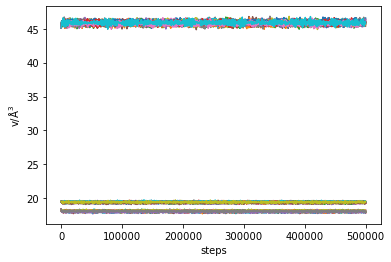

In [4]:
for key in box_equil.keys():
    plt.plot(box_equil[key]['step'],box_equil[key]['lx'])
    plt.plot(box_equil[key]['step'],box_equil[key]['lz'])
    plt.plot(box_equil[key]['step'],box_equil[key]['ly'])
plt.xlabel('steps')
plt.ylabel(r'v/Å$^3$')

In [5]:
box_Ice=[]
for fold in box_equil.keys():
    sim=box_equil[fold]
                                                                                                                                                                             
    u = MDAnalysis.Universe(fold+'/ice.data', in_memory=True)
    NIGNORE=int(0.25*len(box_equil[key]['step']))
    p=fold.split('/')[-1].split('_')[0]
    t=fold.split('/')[-1].split('_')[1]
    box_Ice.append([p,t,np.mean(sim['cella'][NIGNORE:]),
                     np.mean(sim['cellb'][NIGNORE:]),
                     np.mean(sim['cellc'][NIGNORE:]),
                     np.mean(sim['cellalpha'][NIGNORE:]),
                     np.mean(sim['cellbeta'][NIGNORE:]),
                     np.mean(sim['cellgamma'][NIGNORE:])])
with open('avg_ice_box.dat','w') as fp_out:
    for val in box_Ice:
        fp_out.write('{:8}{:8}{:10.5}{:10.5}{:10.5}{:10.5}{:10.5}{:10.5}\n'.format(val[0],val[1],val[2],val[3],val[4],val[5],val[6],val[7]))
!cat avg_ice_box.dat

/data/software/repo/amber/2020/lib/python3.8/site-packages/parmed/utils/netcdf.py:770: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if typecode is not 'c':
/home/sbore/software/miniconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


6000    255         18.056    45.864    20.454    89.622    108.58    90.323
8000    265         17.992    45.808    20.381      89.6    108.48    90.346
7000    250         18.015    45.795    20.408    89.594     108.6    90.343
7000    265         18.022    45.867    20.409     89.67    108.43    90.295
4000    255          18.14    45.979    20.549    89.627    108.69    90.321
6000    260         18.062    45.897    20.461    89.595    108.55    90.357
4000    235         18.112      45.9    20.524    89.608    108.76    90.344
6000    245         18.044    45.827    20.446    89.606    108.64    90.343
8000    275         17.999    45.847    20.384    89.626    108.39    90.321
4000    245         18.127    45.938    20.538    89.608    108.73    90.345
8000    270         17.996    45.825    20.382     89.61    108.44     90.34
7000    270         18.035    45.875    20.425    89.623    108.47    90.328
4000    240         18.122    45.922    20.535    89.615    108.77    90.339